<a href="https://colab.research.google.com/github/lilyzhizhou/ML-Final-Project/blob/main/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applying XGBoost to processed dataset

### Preparation

In [1]:
#import libraries

!pip install category_encoders

import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 90.8 kB/s eta 0:00:00


In [2]:
# Import Pre-Diabetes Data
from google.colab import files
uploaded = files.upload()
datapd = pd.read_csv('datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

datapd.head()

Saving datapd.csv to datapd.csv


,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [3]:
#check dataset shape, variable types, and missing values
print(datapd.shape)
print(datapd.dtypes)
print(datapd.isnull().sum())
#there are 152 missing values for TG

print((datapd['Total_Cholesterol'].isnull().sum() / len(datapd)) * 100)
#this is around 2% of data

(6414, 11)
predm                  int64
Age_at_Exam            int64
BMI                  float64
Total_Cholesterol    float64
Depression             int64
HTN                    int64
OA                     int64
COPD                   int64
corstrd_bin            int64
htnmed_bin             int64
Sex                    int64
dtype: object
predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64
2.369816027439975


In [4]:
#specify columns

# Define the column that will be used as the target for modeling or analysis
target_column = 'predm'

# List of columns that contain categorical data
categorical_columns = ['Depression','HTN', 'OA','COPD','corstrd_bin','htnmed_bin','Sex']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in datapd.columns if c not in categorical_columns and c != target_column]

### Set up model

In [16]:
# Splitting the data into 80% training and validation, and 20% testing
train_80 = datapd.sample(frac=0.8, random_state=42) #random state for reproducibility
test = datapd.drop(train_80.index)

# Split training into 75% training, 25% validation
train = train_80.sample(frac=0.75, random_state=42)
validation = train_80.drop(train.index) 

train.head

# view outcome distribution in all sets

# Compute the count of each class in the 'target' column
print("Training set")
counts = train['predm'].value_counts()
percent_train = (train['predm'].sum()/len(train))
print(counts)
print(percent_train)


print("\nValidation set")
counts = validation['predm'].value_counts()
percent_val = (validation['predm'].sum()/len(validation))
print(counts)
print(percent_val)

print("\nTesting set")
counts = test['predm'].value_counts()
percent_test = (test['predm'].sum()/len(test))
print(counts)
print(percent_test)

# each set appears to have a similar, even distribution of predm outcomes

Training set
0    2297
1    1551
Name: predm, dtype: int64
0.40306652806652804

Validation set
0    755
1    528
Name: predm, dtype: int64
0.41153546375681993

Testing set
0    746
1    537
Name: predm, dtype: int64
0.4185502727981294


In [22]:
# Initializing the Gradient Boosting Classifier with specified parameters
xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Creating a Pipeline:
# only contains Gradient Boosting model, because no column transformations are required
model = Pipeline([('xg_boost', xgboost)])

# Imputation of missing values
#necessary because xgboost gradient boost does not run on data with missing values
#impute from training, use values to fill in NA for both train and test sets
#median used to be more resistant to influence of any outliers

imputer = SimpleImputer(strategy='median')
imputer.fit(train[['Total_Cholesterol']])

# Use this median to fill the NaN values in both training and test sets
train['Total_Cholesterol'] = imputer.transform(train[['Total_Cholesterol']])
validation['Total_Cholesterol'] = imputer.transform(validation[['Total_Cholesterol']])
test['Total_Cholesterol'] = imputer.transform(test[['Total_Cholesterol']])

### Training and initial evaluation

In [26]:
# Training the Gradient Boosting model on the training dataset
model = model.fit(train.drop('predm', axis=1), train['predm']) #using pre-split data

# Predicting on the training dataset and computing the accuracy
Y_pred = model.predict(train.drop('predm', axis=1))
accuracy_score(train['predm'], Y_pred)

# Predicting on the validation dataset and computing the accuracy
Y_pred = model.predict(validation.drop('predm', axis=1))
print(accuracy_score(validation['predm'], Y_pred))
#kind of low

# get initial parameters
print(xgboost.get_params())

0.6445830085736555
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 6, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 40, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### Hyperparamater tuning with grid search

In [27]:
# Defining the hyperparameters to be tuned using GridSearchCV

#using initial parameters
param_dist = {
    "xg_boost__n_estimators" : [75, 100, 150], #total number of trees/boosting rounds
    "xg_boost__max_depth" : [1, 3, 5], #max depth of one tree
    "xg_boost__min_samples_leaf" : [30,40,50], #min samples to be a leaf
    "xg_boost__learning_rate" : [0.05, .1,  .2],
    "xg_boost__max_features" : [4, 6, 8] #max features
}
#runtime: 15 min

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
#skf = StratifiedKFold(n_splits=5)

#use non-stratified Kfold because outcome is balanced
kf = KFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=kf
)

# Fitting the GridSearchCV on the training data
random_search.fit(train.drop('predm', axis=1), train['predm'])

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xg_boost__learning_rate,param_xg_boost__max_depth,param_xg_boost__max_features,param_xg_boost__min_samples_leaf,param_xg_boost__n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
35,0.489772,0.091171,0.00485,0.000776,0.05,3,4,50,150,"{'xg_boost__learning_rate': 0.05, 'xg_boost__m...",...,0.636364,0.667532,0.67013,0.638961,0.641558,0.669271,0.619792,0.649945,0.016587,1


In [28]:
# Retrieve the best hyperparameters after Grid Search
random_search.best_params_

{'xg_boost__learning_rate': 0.05,
 'xg_boost__max_depth': 3,
 'xg_boost__max_features': 4,
 'xg_boost__min_samples_leaf': 50,
 'xg_boost__n_estimators': 150}

### Refit model with optimal hyperparameters

In [29]:
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(train.drop('predm', axis=1), train['predm'])

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(train.drop('predm', axis=1))
train_accuracy = accuracy_score(train['predm'], Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_pred = model.predict(test.drop('predm', axis=1))
test_accuracy = accuracy_score(test['predm'], Y_pred)
print(test_accuracy)
#did not improve
#accuracy not too diff from train to test, so likely not overfit

0.6785343035343036
0.6453624318004677


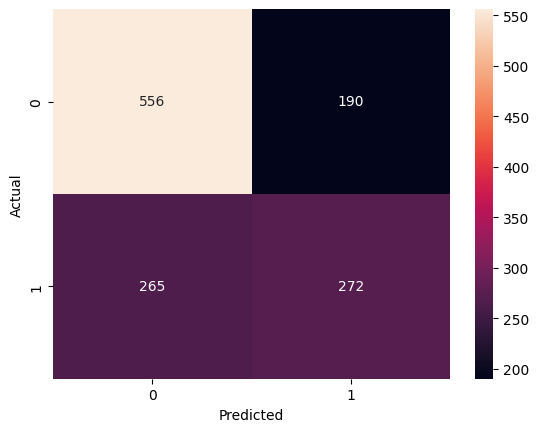

In [33]:
#more evaluation metrics
#confusion matrix
Y = test['predm']
conf_matrix = confusion_matrix(Y, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [34]:
#classification report of various scores
class_report = classification_report(Y, Y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       746
           1       0.59      0.51      0.54       537

    accuracy                           0.65      1283
   macro avg       0.63      0.63      0.63      1283
weighted avg       0.64      0.65      0.64      1283



In [35]:
#AUC
roc_auc = roc_auc_score(Y, Y_pred)
print("Test Set AUC:", roc_auc)

Test Set AUC: 0.6259130009335949
